In [19]:
#biblioteki z arkuszu dr.Więcka
import numpy as np
import seaborn as sns               #do wizualizacji statystycznych
import matplotlib.pyplot as plt
from sklearn import metrics         #do oceny modeli ML
from keras.datasets import cifar10  #nasze dane cifar-10
from keras.utils import to_categorical, set_random_seed         #do etykietowania i ziarna
from keras import layers, models    #do budowania sieci
from random import seed             #losowosc
import tensorflow as tf             #do kerasa - biblioteka od uczenia maszynowego
import plotly.graph_objects as go   #do wykresow interaktywnych

In [ ]:
#Wczytanie i przygotowanie danych cifar-10
set_random_seed(123)
liczba_klas=10 
wielkosc_batcha = 64
epoki = 10
def przygotowanie_danych():
    (X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

    #Normalizacja do zakresu 0-1
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    #Etykietowanie pozwalajace dzialanie - one-hot encoding 
    y_train_cat = to_categorical(y_train, liczba_klas)
    y_test_cat = to_categorical(y_test, liczba_klas)
    return X_train, y_train_cat, X_test, y_test_cat, y_test

X_train, y_train, X_test, y_test, y_test_labels = przygotowanie_danych()

In [21]:
#Tworzenie sieci neuronowych

#Model bazowy
def model_bazowy():
    model = models.Sequential([
        #werstwa wejsciowa
        layers.Input(shape=(32, 32, 3)),
        #1 warstwa
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        #2 warstwa
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        #3 warstwa
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        #warstwa wyjsciowa
        layers.Dense(128, activation='relu'),
        layers.Dense(liczba_klas, activation='softmax')         
    ], name="Baseline")
    return model

#Model dropout (analogicznie jak w schemacie)
def model_dropout():
    model = models.Sequential([
        #warstwa wejsciowa
        layers.Input(shape=(32, 32, 3)),

        #warstwy ukryte:
        #1 warstwa
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Dropout(0.25),             #dodajemy dropout
        layers.MaxPooling2D((2, 2)),
        #2 warstwa
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Dropout(0.25),               #dodajemy dropout
        layers.MaxPooling2D((2, 2)),
        #3 warstwa
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Dropout(0.25),               #dodajemy dropout
        #warstwa gesta (4)
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.35),                #na wyjsciu dajemy wiekszy (tak jak w szablonie)

        #warstwa wyjsciowa
        layers.Dense(liczba_klas, activation='softmax')
    ], name="Dropout")
    return model


#Model Batch normalization na podstawie pliku zaproponowanego od prowadzacego 
#zniesienie biasu (bo i tak sie skroci a jako bias jest przy transformacji parametr beta)
#kolejnosc algorytmu: liniowosc -> transformacja BN -> nieliniowosc
def model_batch_norm():
    model = models.Sequential([
        #warstwa wejsciowa
        layers.Input(shape=(32, 32, 3)),

        #warstwy ukryte:
        #1 warstwa
        layers.Conv2D(32, (3, 3), padding='same', use_bias=False),  #liniowosc
        layers.BatchNormalization(),                                #transformacja
        layers.Activation('relu'),                                  #nieliniowosc
        layers.MaxPooling2D((2, 2)),
        #2 warstwa
        layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        #3 warstwa
        layers.Conv2D(128, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        #warstwa gesta (4)
        layers.Flatten(),
        layers.Dense(128, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        #warstwa wyjsciowa
        layers.Dense(liczba_klas, activation='softmax')
    ], name="Batch_Norm")
    return model

In [22]:
#Trening i ewaluacja
histories = {}
predictions = {}
lista_modeli = [model_bazowy(), model_dropout(), model_batch_norm()]
print(f"\n2. Rozpoczynanie eksperymentów (Epochs={epoki}, Batch={wielkosc_batcha})...")

for model in lista_modeli:
    print(f"\n--- Trenowanie modelu: {model.name} ---")
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    #Trenowanie
    history = model.fit(X_train, y_train, 
                        epochs=epoki, 
                        batch_size=wielkosc_batcha,
                        validation_data=(X_test, y_test),
                        verbose=1)
    
    histories[model.name] = history
    predictions[model.name] = np.argmax(model.predict(X_test), axis=1)


2. Rozpoczynanie eksperymentów (Epochs=10, Batch=64)...

--- Trenowanie modelu: Baseline ---
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.4991 - loss: 1.3858 - val_accuracy: 0.6061 - val_loss: 1.0939
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - accuracy: 0.6615 - loss: 0.9597 - val_accuracy: 0.6523 - val_loss: 0.9912
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.7263 - loss: 0.7864 - val_accuracy: 0.7040 - val_loss: 0.8479
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7710 - loss: 0.6627 - val_accuracy: 0.7151 - val_loss: 0.8499
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.8085 - loss: 0.5573 - val_accuracy: 0.7207 - val_loss: 0.8947
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.8381 - loss: 0.4670 - val_accuracy: 0.7020 - val_loss: 0.9865
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.8658 - loss: 0.3812 - val_accuracy: 0.6987 - val_loss: 1.0

In [23]:
#wizualizacja (za pomoca wykresow interkatywnych)
for name, history in histories.items():
    #historie z treningu
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    x_epochs = list(range(1, len(acc_train) + 1))

    # Kod analogicznie jak w szablonie
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=x_epochs,
                   y=acc_train,
                   name="Accuracy train",
                   line=dict(color="purple")))
    fig.add_trace(
        go.Scatter(x=x_epochs,
                   y=acc_val,
                   name="Accuracy val",
                   line=dict(color="red")))
    
    fig.update_layout(
        title_text=f"Przebieg procesu uczenia: {name}", # Dynamiczny tytuł
        xaxis=dict(title=dict(text="Epoch")),
        yaxis=dict(title=dict(text="Accuracy")),
        updatemenus=[
            dict(
                active=0,
                buttons=list([
                    dict(label="Accuracy train",
                         method="update",
                         args=[{"visible": [True, False]}]),
                    dict(label="Accuracy val",
                         method="update",
                         args=[{"visible": [False, True]}]),
                    dict(label="Both",
                         method="update",
                         args=[{"visible": [True, True]}])
                ]),
            )
        ])
    fig.show()

Wyniki dla 10 epok i 64 batchy:
    - model bazowy - dokładność około 92%
    - model z droput - dokładność około 78%
    - model batch normalization - dokładność około 98% 

Interpretacja:
    - w modelu bazowym wystąpił overfitting 
    - model droput wykazuje bardzo małe różnice pomiędzy val_accuracy i accuracy, choć jest niedouczony - potrzeba więcej epok 
    - batch normalization osiagnal bardzo szybko wysokie accuracy - szybko sie nauczyl (około po 5/6 epokach accuracy już powyżej 90%), i następuje przeuczenie, - rozwiązanie: dodanie dropoutu(?)

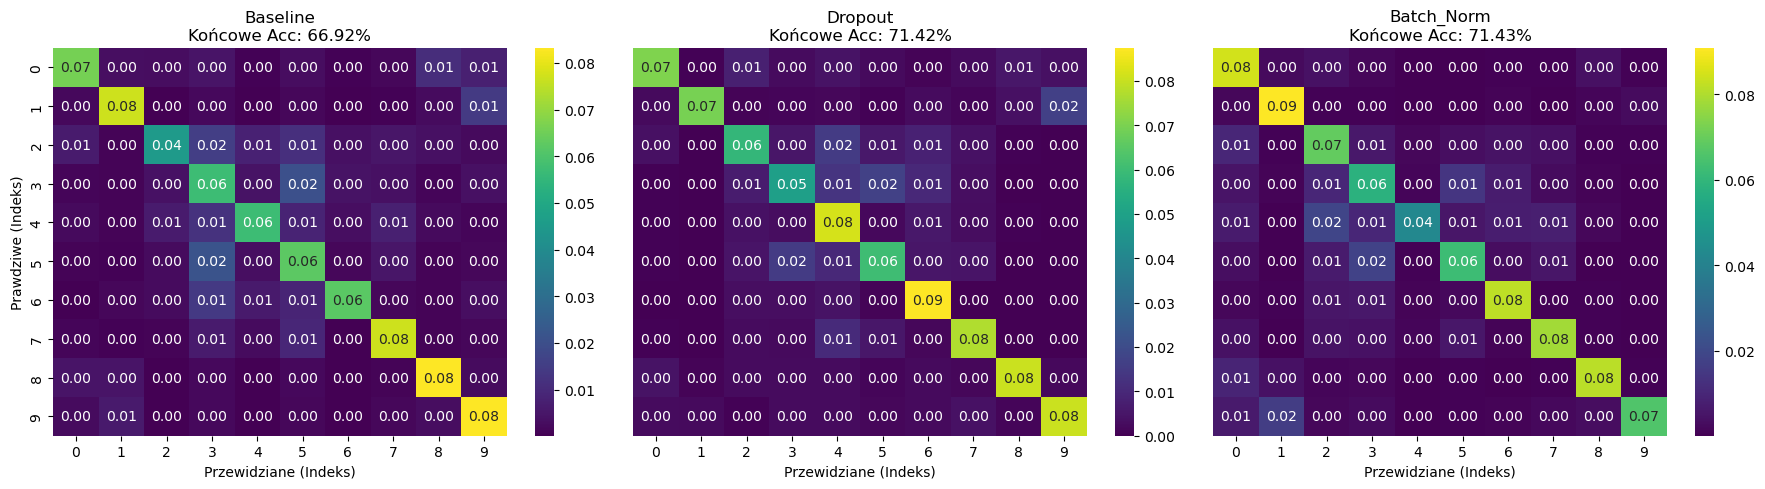

In [24]:
#wizualizacja za pomoca macierzy pomyłek
plt.figure(figsize=(18, 5))
y_true_flat = y_test_labels.flatten()

for i, (name, y_pred) in enumerate(predictions.items()):
    ax = plt.subplot(1, 3, i + 1)
    cm = metrics.confusion_matrix(y_true_flat, y_pred, normalize='all')
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='.2f', ax=ax)
    
    final_acc = histories[name].history['val_accuracy'][-1]
    ax.set_title(f'{name}\nKońcowe Acc: {final_acc:.2%}')
    ax.set_xlabel('Przewidziane (Indeks)')
    if i == 0: ax.set_ylabel('Prawdziwe (Indeks)')
    else: ax.set_yticks([])
    
plt.tight_layout()
plt.show()